***Creating own dataset***

***Step 1***

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In Google Chrome press CtrlShiftj on Windows/Linux and CmdOptj on macOS, and a small window the javascript 'Console' will appear. In Firefox press CtrlShiftk on Windows/Linux or CmdOptk on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

In [ ]:
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [2]:
from google.colab import files
uploaded = files.upload()

Saving urls_doreamon.csv to urls_doreamon.csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving urls_sinchan.csv to urls_sinchan.csv


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
folder = 'doreamon'
url_file = 'urls_doreamon.csv'
path = Path('my_data')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(url_file, dest, max_pics=1000)

In [5]:
folder = 'sinchan'
url_file = 'urls_sinchan.csv'
path = Path('my_data')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(url_file, dest, max_pics=1000)


In [6]:
classes = ['doreamon','sinchan']

In [7]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

doreamon


sinchan


In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes

['doreamon', 'sinchan']

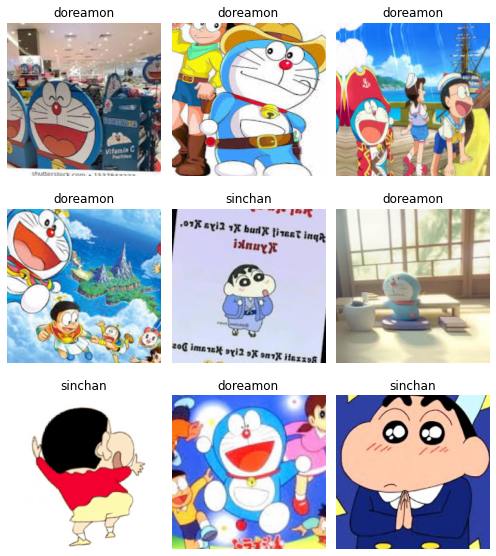

In [10]:
data.show_batch(rows=3, figsize=(7,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['doreamon', 'sinchan'], 2, 729, 182)

In [15]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [16]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.749718,0.441918,0.170330,00:10
1,0.584790,0.397019,0.093407,00:10
2,0.480757,0.284961,0.065934,00:10
3,0.383269,0.287646,0.076923,00:11
4,0.320129,0.211193,0.043956,00:10
5,0.258306,0.211173,0.065934,00:11
6,0.218597,0.205924,0.054945,00:10
7,0.188695,0.209725,0.076923,00:10


In [17]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:
os.makedirs("/content/drive/My Drive/dl_projects/sinora",exist_ok=True)

In [19]:
my_dir="/content/drive/My Drive/dl_projects/sinora"

In [20]:
learn.save(my_dir+"/Stage-1")

In [21]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.131362,0.216428,0.065934,00:12
1,0.142706,0.427794,0.087912,00:12
2,0.201325,0.303144,0.054945,00:12
3,0.188258,0.226040,0.060440,00:12
4,0.165417,0.134884,0.038462,00:12
5,0.140531,0.166841,0.049451,00:11
6,0.111386,0.147150,0.043956,00:12
7,0.091962,0.143889,0.054945,00:12


In [25]:
learn.save(my_dir+"/Stage-2")

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

***OverFitting and underfitting***

![alt text](https://miro.medium.com/max/1648/1*JZbxrdzabrT33Yl-LrmShw.png)


All of statistics is about how you use information from a specific sample to make general statements about a larger population (that you cannot observe in full).

***Overfitting ***is when your conclusion is too specific to the observed sample, i.e. not general enough. You usually cure over-fitting by reducing the complexity of your model.

***Underfitting ***is when your conclusion is too general - that means you’re not learning enough from your sample. You usually cure under-fitting by increasing the complexity of your model.

Example: predict who will be an “A” student in college.

Let’s say “Peter Evans Hope” is an “A” student in your dataset. If your model says anyone named “Peter Evans Hope” is an “A” student, the model will correctly predict this specific student but it is over-fitted because in the general population, there probably isn’t another “Peter Evans Hope” (and if there is, probably not an “A” student).

If your model says anyone who graduated from [insert top high school] will be an “A” student in college, this is underfitting (too general). Within the graduates from that high school, there will be a range of college GPAs - what else can explain who gets the “A”?

***Differential learning Rates***

The phrase “Differential learning rates” means to have different learning rates for different parts of the network during our training. The idea is to divide the layers into various layer groups and set different learning rate for each group so that we get ideal results. In simple terms, we control the rate at which weights change for each part of our network during training.

***Why? How does it help?***

If we consider the above approach above, there is a small but significant point to be noticed. To understand it let’s look at our sample CNN figure.


![alt text](https://miro.medium.com/max/651/1*4zrt6IeIhv55mUskGhXR7Q.png)

In general, layers in red learn generic features like edges, shapes and the middle blue layers learn specific details with respect to the dataset on which it is trained.
Given the above statement, it’s not a good idea to change the learned weights on the initial layers too much because they are already good at what they are supposed to do (detecting the features like edges etc). Middle layers will have knowledge of the complex features that might help our task to some extent if we slightly modify them. So, we want to finetune them a little.

Differential learning rates help us in this regard. We can now imagine sample network into three layer groups (red, blue and green) and set different learning rates. The initial red layers will have small learning rate as we don’t want to disturb them much, the middle blue layers will have learning rate higher than initial layers and the final green layers will be having the highest learning rate that’s optimal.

How less/more the learning rates for initial and middle layers depends on the data correlation between the pre-trained model and our required model. For example, if the task is to create a dog/cat classifier and our pre-trained model is already good at recognizing cats, then we can use learning rates of less magnitude. But if our task is to create some model on satellite imagery/medical imagery then we will have learning rates of slightly higher magnitude.

**Please note that most of the deep learning libraries currently do not support differential learning rates(but fastai supports)**